In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.sixb.feynnet

In [3]:
use_signal = [ i for i, m in enumerate(module.full_signal_6b_list) if m in module.signal_6b_list ]

In [4]:
def use_test(f):
    return f.replace('ntuple','test_ntuple')

In [5]:
signal = ObjIter([Tree(use_test(f), report=False, ) for f in tqdm(module.full_signal_6b_list)])
bkg = ObjIter([Tree(map(use_test,module.Run2_UL18.QCD_B_List))])

100%|██████████| 16/16 [00:04<00:00,  3.51it/s]


In [6]:
import utils.sixbUtils as sixb

model = sixb.models.feynnet_sig
(signal + bkg).apply( lambda t : sixb.weaver.load_yh_trih_ranker(t, model.path), report=True )

100%|██████████| 9/9 [00:32<00:00,  3.64s/it]


[None, None, None, None, None, None, None, None, None]

In [19]:
def fully_reconstructed(t):

    reco_hx = t.HX_signalId == 0
    reco_y  = ( (t.H1_signalId+1)//2 == 1) & ( (t.H2_signalId+1)//2 == 1)
    
    reco_id = ak.where( reco_hx & reco_y, 0, -1)
    t.extend(
        reco_id = reco_id
    )
(signal).apply(fully_reconstructed)

[None, None, None, None, None, None, None, None]

In [20]:
sixb_signal = signal.apply(EventFilter('all_sixb', filter=lambda t : t.nfound_select==6))
partial_signal = signal.apply(EventFilter('partial_sixb', filter=lambda t : t.nfound_select< 6))

100%|██████████| 1/1 [00:00<00:00,  7.14it/s]


x_mean=3.500
x_std=2.291
x_min=0.000
x_max=7.000
y_mean=0.745
y_std=0.064
y_min=0.642
y_max=0.857
x_sum=28.000
y_sum=5.963
area=5.153
ndf=8.000


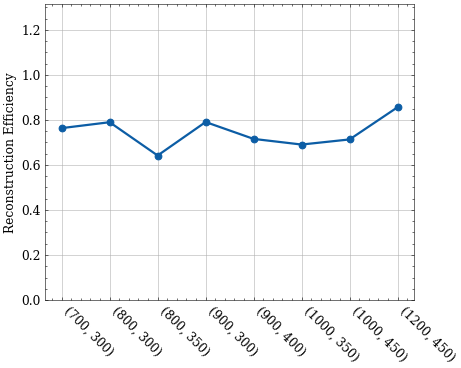

In [21]:
study.statsplot(
    sixb_signal,
    label=signal.mass.list,
    varlist=['reco_id'],
    binlist=[np.array([-1,0,1])],
    xlabels=['Reconstruction Efficiency'],
    efficiency=True,

    stat=lambda h:h.histo[-1],
    stat_err=lambda h:h.error[-1],
    g_grid=True,

    g_exe=lambda graph, **kwargs: print( f'{graph.stats:0.3f}'),
)

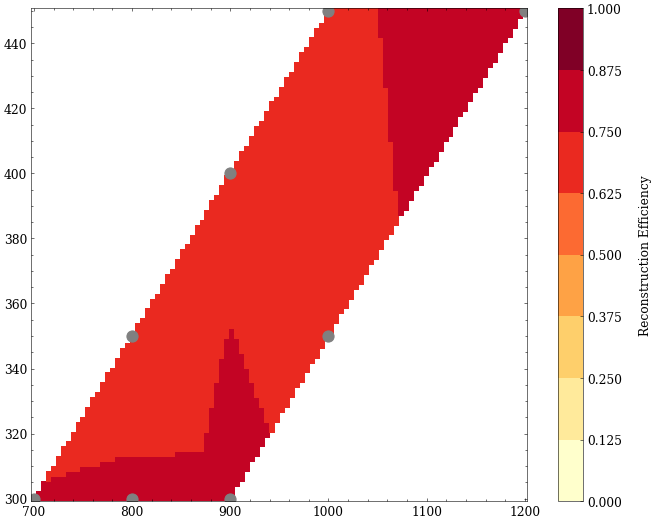

In [22]:
study.mxmy_phase(
    sixb_signal,
    label=signal.mass.list,
    zlabel='Reconstruction Efficiency',
    efficiency=True,

    f_var=lambda t: ak.mean(t.reco_id==0),
    zlim=np.linspace(0,1,9),
)

100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


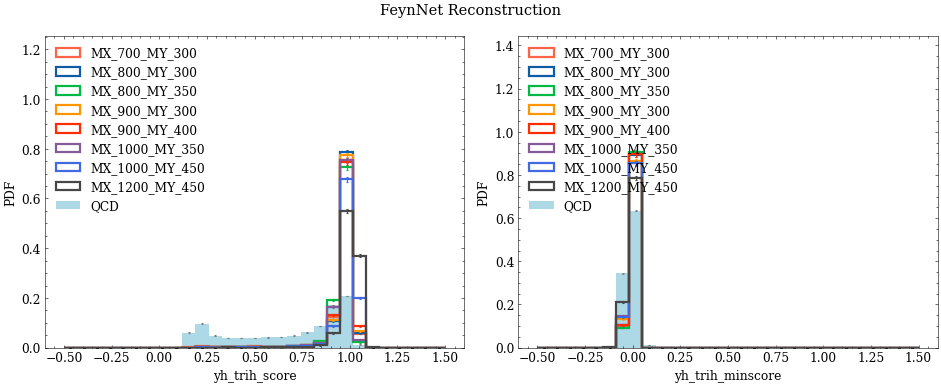

In [23]:
study.quick(
    sixb_signal+bkg,
    legend=True,
    h_label_stat=None,
    varlist=['yh_trih_score','yh_trih_minscore'],
    binlist=[(-0.5,1.5,30)]*2,
    suptitle='FeynNet Reconstruction',
    efficiency=True,
    lumi=None,
    # **study.auroc,
)

In [24]:
varinfo.X_m =   dict(bins=(400,2000,30), xlabel='$M_{X}$ (GeV)')
varinfo.Y_m =  dict(bins=(100,1000,30), xlabel='Y Boson Mass (GeV)')
varinfo.HX_m =   dict(bins=(0,300,30), xlabel='X\'s Higgs Boson Mass (GeV)')
varinfo.H1_m =   dict(bins=(0,300,30), xlabel='Y\'s Leading Higgs Boson Mass (GeV)')
varinfo.H2_m =   dict(bins=(0,300,30), xlabel='Y\'s Subleading Higgs Boson Mass (GeV)')


100%|██████████| 6/6 [00:02<00:00,  2.58it/s]


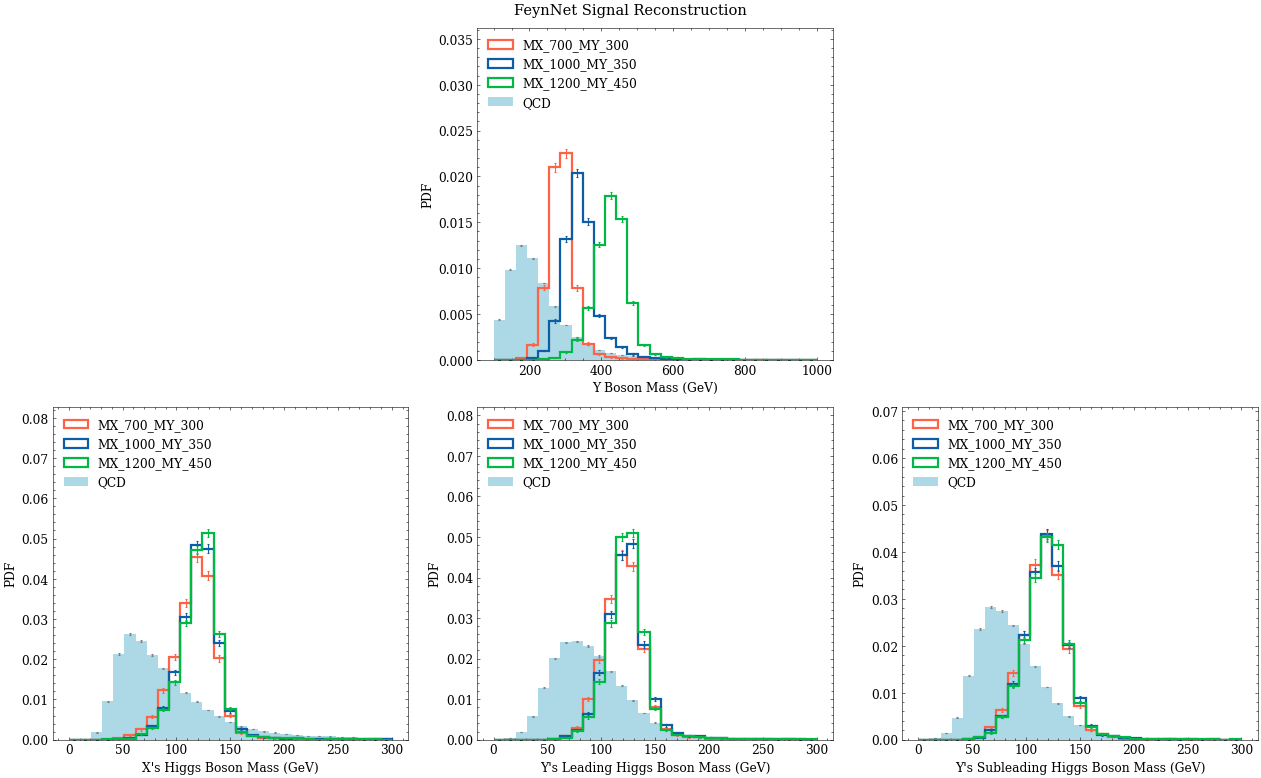

In [25]:
study.quick(
    sixb_signal[use_signal]+bkg,
    legend=True,
    h_label_stat=None,
    varlist=[None,'Y_m',None,'HX_m','H1_m','H2_m'],
    suptitle='FeynNet Signal Reconstruction',
    lumi=None,
    density=True,
)